In [32]:
from datetime import datetime
import pandas as pd
import numpy as np
import csv
from vzorci_in_pomozne_definicije import *

Opomba: JSON ohranja tipe spremenljivk!! Morda bom popravil analizo tako, da ne delam s csv-jem ampak JSON-om.

In [33]:
podatkovna_baza = pd.read_json(FILENAME_POPOLNI_PODATKI_KARTE_JSON)

KeyboardInterrupt: 

<AxesSubplot: >

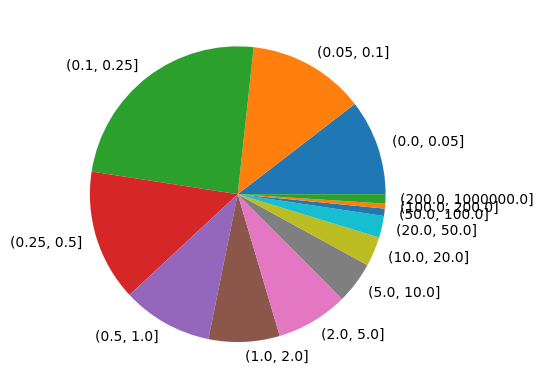

In [ ]:
cenovni_razredi_kart = np.array([0, 0.05, 0.10, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 1000000])
podatki_po_ceni_eu = podatkovna_baza.groupby(pd.cut(podatkovna_baza["povprecje_eu"], cenovni_razredi_kart)).size()
podatki_po_ceni_us = podatkovna_baza.groupby(pd.cut(podatkovna_baza["povprecna_cena"], cenovni_razredi_kart)).size()
#pd.merge(podatki_po_ceni_eu, podatki_po_ceni_us).plot(kind = "bar")
podatki_po_ceni_eu.plot(kind = "pie")

# Tukaj je treba porihtati, da dobimo primerjavo ameriških cenovnih razredov z evropskimi

In [36]:
povprecna_cena_glede_na_redkost = podatkovna_baza.groupby("redkost")["povprecna_cena"].mean()
mediana_cena_glede_na_redkost = podatkovna_baza.groupby("redkost")["povprecna_cena"].median()   
modus_cena_glede_na_redkost = podatkovna_baza.groupby("redkost")["povprecna_cena"].value_counts()
#povprecna_cena_glede_na_redkost.plot(kind="bar")
modus_cena_glede_na_redkost #.plot(kind="bar")

redkost   povprecna_cena
Common    0.20              1839
          0.25              1806
          0.24              1152
          0.23               777
          0.22               484
                            ... 
Uncommon  4499.97              1
          5087.65              1
          9500.00              1
          9998.98              1
          10000.00             1
Name: povprecna_cena, Length: 6272, dtype: int64